# Classification using importance-weighted SGPR

This notebook explains how to use Markovflow to build and optimise a GP classifier (in 1D of
course!) using importance-weighted variational inference.

In [1]:
import numpy as np
import tensorflow as tf
from gpflow.ci_utils import ci_niter
from gpflow.likelihoods import Bernoulli

from markovflow.models.iwvi import ImportanceWeightedVI
from markovflow.kernels import Matern32

import matplotlib.pyplot as plt

2022-09-17 14:45:26.655567: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-09-17 14:45:26.655599: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Setup
learning_rate = 1e-3
importance_K = 10

# toy data
num_data = 100
time_points = np.linspace(0, 10, num_data).reshape(-1,)
observations = np.cos(2*np.pi * time_points / 3.).reshape(-1, 1) + np.random.randn(num_data, 1) * .8
observations = (observations > 0).astype(float)
data = (tf.convert_to_tensor(time_points), tf.convert_to_tensor(observations))

2022-09-17 14:45:28.313421: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-17 14:45:28.313608: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-09-17 14:45:28.313620: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-17 14:45:28.313640: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az178-774): /proc/driver/nvidia/version does not exist
2022-09-17 14:45:28.313898: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F F

In [3]:
# model setup
num_inducing = 20
inducing_points = np.linspace(-1, 11, num_inducing).reshape(-1,)
kernel = Matern32(lengthscale=2.0, variance=4.0)
likelihood = Bernoulli()
m = ImportanceWeightedVI(kernel=kernel,
                         inducing_points=tf.constant(inducing_points, dtype=tf.float64),
                         likelihood=likelihood,
                         num_importance_samples=importance_K)

In [4]:
# optimizer setup
variational_variables = m.dist_q.trainable_variables
hyperparam_variables = m.kernel.trainable_variables
adam_variational = tf.optimizers.Adam(learning_rate)
adam_hyper = tf.optimizers.Adam(learning_rate)

_dregs = lambda: -m.dregs_objective(data)
_iwvi_elbo = lambda: -m.elbo(data)

@tf.function
def step():
    adam_variational.minimize(_dregs, var_list=variational_variables)
    adam_hyper.minimize(_iwvi_elbo, var_list=hyperparam_variables)

@tf.function
def elbo_eval():
    return m.elbo(data)

2022-09-17 14:45:28.375297: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [5]:
# a function to plot the data and model fit

def plot(model):

    time_grid = np.linspace(0, 10, 200).reshape(-1,)

    num_samples = 50
    samples_q_s = model.posterior.proposal_process.sample_state(time_grid, num_samples)
    samples_iwvi = model.posterior.sample_f(time_grid, num_samples, input_data=data)

    _, axarr = plt.subplots(2, 1, sharex=True, sharey=True)
    # plot data
    axarr[0].plot(time_points, observations, 'kx')
    axarr[0].set_title('proposal')
    axarr[0].plot(time_grid, samples_q_s[..., 0].numpy().T, alpha=.1, color='red')

    axarr[1].plot(time_points, observations, 'kx')
    axarr[1].set_title('importance-weighted')
    axarr[1].plot(time_grid, samples_iwvi[..., 0].numpy().T, alpha=.1, color='blue')
    axarr[1].set_ylim(-1.5, 2.5)

    # plot mean by numerically integrating the iwvi posterior
    eps = 1e-3
    inv_link = lambda x : eps + (1-eps) * likelihood.invlink(x)
    probs = m.posterior.expected_value(time_grid, data, inv_link)
    axarr[1].plot(time_grid, probs, color='black', lw=1.6)

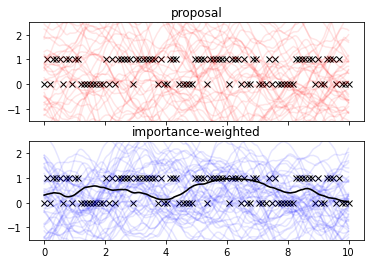

In [6]:
plot(m)

In [7]:
# the optimisation loop
elbos, elbo_stds = [], []
max_iter = ci_niter(2000)
for i in range(max_iter):
    step()
    if i % 10 == 0:
        elbos_i = [elbo_eval().numpy() for _ in range(10)]
        elbos.append(np.mean(elbos_i))
        elbo_stds.append(np.std(elbos_i))
        print(i, elbos[-1], elbo_stds[-1])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


2022-09-17 14:45:41.440699: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-17 14:45:41.544291: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2793435000 Hz


2022-09-17 14:45:42.782119: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: assert_equal_29/Assert/AssertGuard/branch_executed/_39


2022-09-17 14:45:47.497460: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: assert_equal_29/Assert/AssertGuard/branch_executed/_74


0 -101.07634022289207 16.27635866120352
10 -96.45509094087672 11.20627968709978
20 -98.41289256754695 10.387425162359936
30 -102.63460563663777 10.54773227675219


40 -95.67319542723098 11.236248881790855
50 -99.75972755012552 14.541896167970753
60 -99.42288450927897 11.403238151210154
70 -98.41779762749835 12.969012713937062


80 -95.29100498688106 9.77434691674959
90 -97.90446742774422 13.643605238257319
100 -100.20661640368152 13.800911920617256
110 -94.64449769692186 9.905287689209821


120 -88.43746057820394 11.083698912020488
130 -97.21399935213094 7.163098565639439
140 -96.31273604800283 8.389328625245112
150 -89.04686273131395 6.150217299439492


160 -89.83976327484416 10.280488769038792
170 -88.97746058941827 7.523897250209999
180 -85.99612956997716 10.395301456528472
190 -90.02110549333415 11.069546298418809


200 -96.55510116897383 12.969798428582475
210 -93.05345476127304 8.31411610830384
220 -88.21424778165107 9.486117236890836
230 -87.69331791180176 8.58219330330066


240 -92.59848993226845 9.597397596852966
250 -86.95743298266369 6.882942491501733
260 -90.64915536691451 6.012142042129953
270 -86.33696070580459 3.795916614993473


280 -86.91449740287896 3.798419146890139
290 -87.98056901314031 4.866400416140885
300 -91.76603567823328 9.052055770771586
310 -82.44695877935703 8.019775583815658


320 -82.96710168797742 4.9934280934281166
330 -81.29836169784342 5.943383098061257
340 -87.6779711059792 9.665497825422847
350 -83.87437241027312 5.304405514231904


360 -83.13183537938002 5.589080125353829
370 -86.19228059633797 6.915805607316601
380 -92.97754926867465 6.2562606942260235
390 -84.02382727067203 7.319283525827754


400 -81.44666699256278 5.83846413968351
410 -81.45225070880898 9.327622030107944
420 -78.8603057819478 4.464784476075889
430 -81.56054209063521 5.363080738236613


440 -82.6858604593629 9.243598327076507
450 -81.29478478029334 4.149513614963916
460 -79.48802126026058 8.470216312420582
470 -82.4671751452358 4.83862449033195


480 -80.50654916853247 4.25440185261073
490 -82.60543385671922 5.354164143068351
500 -88.43657961358507 3.9652573306327548
510 -81.75283071419842 6.49633893842868


520 -82.18656935040951 6.07914793445895
530 -83.34622830321038 5.841989174575491
540 -80.98243099115292 7.747412589563766
550 -80.94269154213502 5.379796490944193


560 -81.3676554451884 2.394122379438667
570 -80.7207912545872 4.924518955479584
580 -79.1976527292829 4.866822600000239
590 -78.58548486510391 5.901172534871833


600 -78.59082863033822 2.4308431001365873
610 -80.6552621837716 5.887720852070166
620 -78.484215306437 4.741898857555426
630 -82.13049110189428 4.844480386172714


640 -77.16680826129696 4.187696959227382
650 -82.56746972976303 5.2293443370108745
660 -80.00126289377508 4.626715686403001
670 -77.58095091413801 4.900570812068766


680 -79.16232816934806 5.372864902445398
690 -79.4518909577025 4.1169101910739965
700 -79.0529587462661 6.805849792552489
710 -79.59521999854412 4.600462438208441


720 -75.95375001519976 4.218567975801361
730 -79.04577812566068 4.519239973514153
740 -79.20637218707859 5.630413980471827
750 

-77.57335666216922 5.3097005707435585
760 -76.20871618896935 3.9395858814858142
770 -78.95056386413064 4.176546687344374
780 -77.41767852460798 4.56734141426978


790 -79.29018809132253 5.140016874839529
800 -78.87276238773991 3.451446936793078
810 -79.07594397433714 3.648742814966345
820 -76.64557294385096 3.9560111210291566


830 -77.76013981318283 4.466067608928239
840 -78.69101122963421 4.252660915787601
850 -79.19854279104504 3.112426932409684
860 -77.66161447301334 4.351590282778329


870 -77.54230056703352 2.568892274603974
880 -76.22494029401037 2.081878961461302
890 -78.35464543915973 2.813704546670033
900 -78.30919927942435 2.2431934054365334


910 -76.93759012036926 3.164248668034544
920 -76.99076803906878 3.543012282992753
930 -78.8930553355348 2.363900389119484
940 -75.83992719815 3.234306845635459


950 -76.19186242208283 2.885623752194865
960 -76.51773934863562 3.856578167522965
970 -76.383135180255 3.23324552720812
980 -76.6413814205321 2.8637808953875035


990 -75.54021745364673 2.952943223193498
1000 -75.2561951341165 2.863177645772928
1010 -76.34434396756482 3.3101857801781804
1020 -75.21992877581489 2.1370366674993733


1030 -75.3508434735813 3.3465053585077578
1040 -75.14378704930606 3.0412897087002984
1050 -77.31740494953144 3.848367775975159
1060 -75.81443575857502 3.2548754077884454


1070 -74.34003882193609 3.0463184756262884
1080 -76.04083263062134 3.7928741360496336
1090 -75.65442915025226 2.491746048434601
1100 -75.4201960985985 3.2584761545975036


1110 -75.60157284811643 3.0945936308245656
1120 -75.21314680113954 3.2617898466086954
1130 -75.71416304631491 2.180457475417476
1140 -74.8135530866866 2.2728582140889078


1150 -76.17059993374238 3.805120808541676
1160 -75.64315104509423 2.8847173859460487
1170 -74.48487953605574 3.951998982709164
1180 -76.00286091979451 2.920458461939291


1190 -73.63520323162268 2.447338377453209
1200 -75.44572040369867 2.829703641131903
1210 -74.26812730880481 2.6200693179238073
1220 -75.19105429487236 3.0893885840364685


1230 -75.24153709831974 2.854221742607697
1240 -74.42006341215075 2.265640592059181
1250 -74.17214233022176 1.8896442059065652
1260 -73.90329306989203 2.7396564016484506


1270 -75.44169293453481 2.4999063503483994
1280 -75.38086238697723 2.29757016534756
1290 -75.6633991173847 3.8461958237362297
1300 -74.82647287920221 2.5934139396750373


1310 -73.91541911501498 1.5039315632587515
1320 -74.72823838594252 1.610479503463146
1330 -74.75146316681591 2.140974971267462
1340 -73.70744329283107 2.1109989139284155


1350 -74.4484108268004 1.8266270070346984
1360 -72.49646762724943 2.667177249624395
1370 -74.12227188314795 2.215851471060054
1380 -73.98142344005132 2.2723404710689503


1390 -73.55346613674887 1.7267139675539163
1400 -75.64537654769865 2.2866168505338793
1410 -74.8783777740058 2.0964903635042145
1420 -74.24207840347853 1.3954816687869545


1430 -73.82713981942501 1.8684165538810154
1440 -74.65588383941864 3.2497297548909043
1450 -73.30513114957051 1.748806780283366
1460 -74.68074242699149 1.3989419744682596


1470 -74.45509641558007 1.7444364215999353
1480 -74.72247228796644 2.474333238041562
1490 -74.30964747354993 2.2782657695290904
1500 -75.28775103901967 2.196427326980512


1510 -74.76228545046938 1.9741288642073997
1520 -73.76442925468123 1.8080530731755808
1530 -71.88947375392297 1.6936596604532825
1540 -73.96315518439397 2.2731997793830367


1550 -73.62821000552906 1.5552283424218294
1560 -75.20355153027693 2.6217351490810437
1570 -73.47728964160873 1.5650514343906001
1580 -74.5965134228729 1.5449312916050546


1590 -73.81994364670966 1.7380780773921836
1600 -73.91129807602277 1.2359996589596998
1610 -73.77707340693887 1.368538368281696
1620 -72.92218501225797 1.658405649340303


1630 -73.91710576033857 1.6152943474251409
1640 -73.48115831705829 1.628078924030334
1650 -74.4566935091877 1.1299608354699044
1660 -72.97384693337185 1.9503522821773955


1670 -73.70890047088415 1.953094866227988
1680 -74.05213046698212 2.2709549705755623
1690 -73.08035782399506 1.5139735601601503
1700 -74.81518966314641 2.943568545567902


1710 -74.08616400903735 2.09459781667846
1720 -73.6344186474048 1.1699157195422936
1730 -73.11745677994098 1.4235632344628104
1740 -74.33443932499627 2.1867045966270435


1750 -74.02776807334689 1.6321116762058399
1760 -73.38773180890013 1.0454028438734184
1770 -73.8721939532624 1.9531030184044105
1780 -74.04353550289761 1.5514205563985566


1790 -73.82483352543412 0.9692439250354591
1800 -74.56481709879158 2.1172160805106093
1810 -73.79224899764108 1.642226560467826
1820 -72.89465039893665 1.6288384634775739


1830 -73.64284590207113 1.467368736401556
1840 -73.03432467107737 1.5179436218928613
1850 -73.94103571488044 1.5823933480709171


1860 -74.236462469095 2.2191802213986747
1870 -74.09270300743358 2.023411720426064
1880 -73.28091128229174 1.1044506627062705
1890 -74.39870413076949 2.408007516859078


1900 -74.32008018709934 1.3495782686711777
1910 -72.83140542323048 1.30484595581399
1920 -73.08658881683425 1.8376688830535906
1930 -72.92224726246437 1.544783849899564


1940 -72.87199582058035 1.3269138152994442
1950 -72.78048783097368 0.9217074807706788
1960 -72.97865733414292 1.655359123906779
1970 -72.95736685448165 1.3300611746962614


1980 -73.3775114616992 1.9595937462234654
1990 -72.99996471307723 1.866423239496731


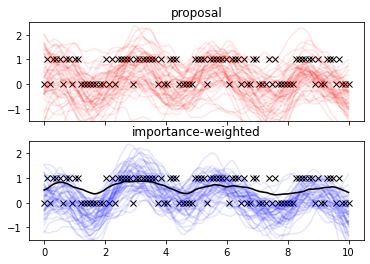

In [8]:
plot(m)